<a href="https://colab.research.google.com/github/mhanauer/xgboost_drop_out_colab/blob/master/xgboost_drop_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# To make things easier later, we're also importing numpy and pandas for
# working with sample data.
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [5]:
# import new data
from google.colab import files
drop_out_dat = files.upload()
drop_out_dat = pd.read_csv("drop_out_8_10_20.csv", delimiter = ",", na_values = [-99, -98, -1, -2, -3, -4, -5, -6, -7, -8, -9])
drop_out_dat

Saving drop_out_8_10_20.csv to drop_out_8_10_20.csv


,Quarter,Gender,RaceWhite,RaceBlack,Agegroup,OverallHealth,CapableManagingHealthCareNeeds,HandlingDailyLife,ControlLife,DealWithCrisis,GetsAlongWithFamily,SocialSituations,FunctioningHousing,Symptoms,Nervous,Hopeless,Restless,Depressed,EverythingEffort,Worthless,PsychologicalEmotionalProblems,LifeQuality,EnoughEnergyForEverydayLife,PerformDailyActivitiesSatisfaction,HealthSatisfaction,RelationshipSatisfaction,SelfSatisfaction,Tobacco_Use,Alcohol_Use,Cannabis_Use,ViolenceTrauma,Housing,Education,Employment,EnoughMoneyForNeeds,Friendships,EnjoyPeople,BelongInCommunity,SupportFromFamily,SupportiveFamilyFriends,GenerallyAccomplishGoal,telehealth,grant,EverServed,ActiveDuty_Else,NightsHomeless,drop_out,aiety,mdd_r,mdd_s,another_s_ident,drug_use,er_hos_use_base,jail_arrest_base
0,2,1.0,0.0,1.0,8.0,4.0,3.0,2.0,3.0,2.0,3.0,2.0,4.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,2.0,NaN,4.0,4.0,1.0,2.0,1.0,1.0,12.0,0.0,4.0,4.0,2.0,4.0,3.0,3.0,4.0,0,0,0.0,2.0,0.0,0,NaN,NaN,NaN,0.0,9.0,0.0,0.0
1,1,0.0,1.0,0.0,6.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,4.0,5.0,4.0,5.0,3.0,4.0,2.0,1.0,1.0,1.0,0.0,13.0,1.0,2.0,5.0,4.0,4.0,4.0,4.0,4.0,0,0,0.0,0.0,12.0,0,NaN,NaN,NaN,1.0,12.0,0.0,0.0
2,1,0.0,1.0,0.0,8.0,2.0,1.0,2.0,4.0,4.0,1.0,5.0,1.0,2.0,4.0,4.0,4.0,3.0,3.0,4.0,5.0,2.0,4.0,5.0,5.0,NaN,NaN,4.0,1.0,1.0,1.0,0.0,14.0,0.0,3.0,2.0,4.0,4.0,2.0,5.0,5.0,0,0,0.0,0.0,26.0,0,NaN,NaN,NaN,0.0,9.0,4.0,2.0
3,1,1.0,1.0,0.0,7.0,4.0,2.0,2.0,2.0,4.0,1.0,4.0,1.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,1.0,0.0,14.0,0.0,1.0,3.0,2.0,1.0,2.0,2.0,4.0,0,0,0.0,2.0,30.0,0,NaN,NaN,NaN,0.0,9.0,0.0,0.0
4,2,0.0,0.0,1.0,7.0,2.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,14.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,0,0,0.0,2.0,0.0,0,NaN,NaN,NaN,0.0,12.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,2,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2093,3,1.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,0.0,0.0,0.0,NaN,NaN,0.0,NaN
2094,4,0.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,1.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,0.0,0.0,1.0,NaN,NaN,0.0,NaN
2095,4,0.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,1.0,0.0,0.0,NaN,NaN,0.0,NaN


In [48]:
y = drop_out_dat[["drop_out"]]
predictors = drop_out_dat.drop(["drop_out"], axis = 1)
### Needed to get y in the correct format
y = y.values.ravel()
## Save for later to keep predictor names
predictors_names = predictors
### Needed for xgboost
predictors = predictors.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(predictors, y, test_size = .20, random_state = 53)

In [57]:
dtrain = xgb.DMatrix(data = X_train, label=y_train)
dtest = xgb.DMatrix(data = X_test, label=y_test)


For scale_pos_weight, generally take the sum(neg) / sum(pos) are starting point for imbalanced data sets.


In [33]:
y_ratio = drop_out_dat[["drop_out"]]
y_ratio = 1-y_ratio.mean(axis=0)
y_ratio 

drop_out    0.725799
dtype: float64

Develop a pipline for cleaner inclusion of hyparameter tuning
Then run randomized grid search through the hyperparameters. 

In [77]:
### 
from sklearn.feature_selection import RFECV
pipe = Pipeline([
    ("classifer", XGBClassifier())
])
params = dict(  
    classifer__max_depth=[6,12,15, 18],
    classifer__eta= [.01, .001, .3, .4, .5, .6, .7],
    classifer__colsample_bytree=[.3, .4,.5, .6, .7, .8, .9],
    classifer__subsample= [.5, .6, .7],
    classifer__lambda=[1, 1.1, 1.2, 1.3, 1.4],
    classifer__alpha= [0, .1, .2, .3],
    classifer__scale_pos_weight = [ 0.725799,  0.725799+.1,  0.725799-.1]
    )
gs = RandomizedSearchCV(pipe, params, n_jobs=-1, cv = 10)
gs = RFECV(gs, step = 1, cv = 10)
gs.fit(X_train, y_train)

ValueError: ignored

In [70]:
best_model = XGBClassifier(params = gs.best_estimator_)  # and for classifier
best_model.fit(X_train, y_train)
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params=Pipeline(memory=None,
                              steps=[('classifer',
                                      XGBClassifier(alpha=0.2, base_score=0.5,
                                                    boost...
                                                    max_delta_step=0,
                                                    max_depth=12,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=100, n_jobs=1,
                                                    nthread=None,
                 

Leaves are log odds so take 1/(1+ np.exp(-(leaf))) to get the probabilities.  

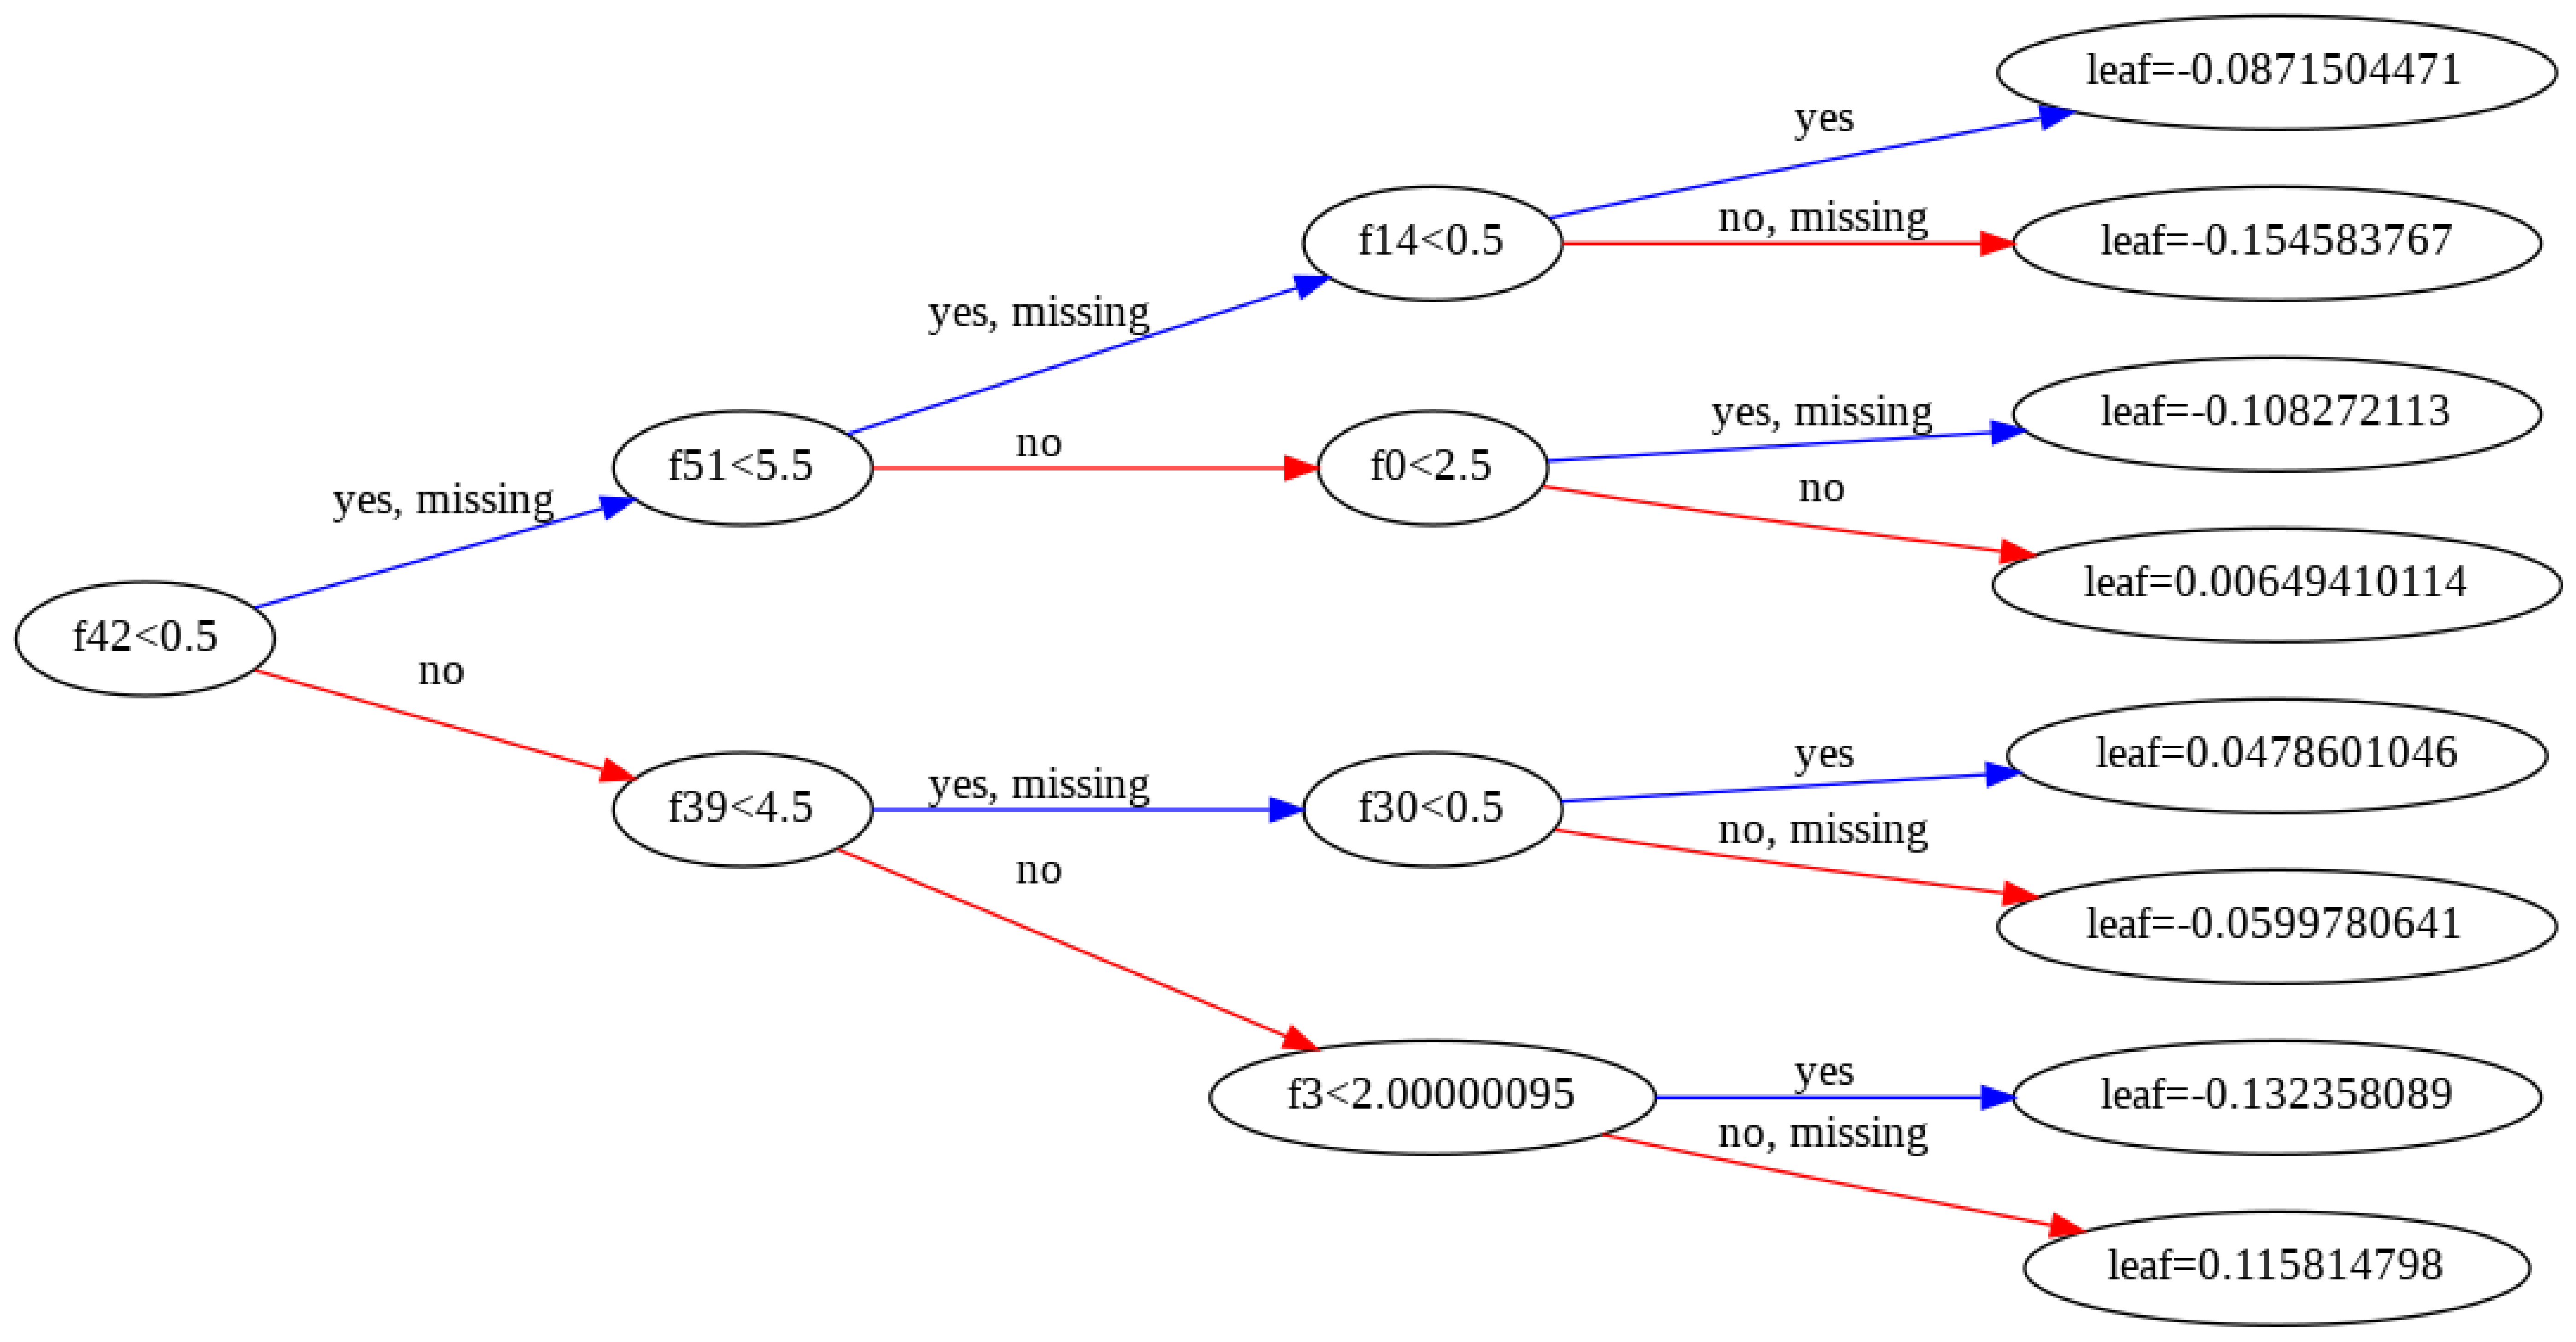

In [76]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from xgboost import plot_tree
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 100,80
tree_plot = plot_tree(best_model, num_trees = 2, rankdir='LR')
tree_plot

In [61]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
pred_auc = gs.predict_proba(X_test)
pred_auc =  pred_auc[:,1]
precision, recall, thresholds = precision_recall_curve( y_test, pred_auc)
# Find the thresholds that produces the maximum precision and recall
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
thresholds[ix]

Best Threshold=0.283148, F-Score=0.787


0.28314835

In [62]:
### Need to get the predicted probabilities
pred_prob =  gs.predict_proba(X_test)
prob_drop =   pd.DataFrame(pred_prob[:,1], columns = ["prob_drop"])
def if_else(row):

    if row['prob_drop'] >thresholds[ix]:

        val = 1
    
    else:

        val = 0

    return val

prob_drop = prob_drop.apply(if_else, axis=1)
prob_drop

### Get a confusion matrix and then get sensitivity by hand
con_mat = confusion_matrix(y_test, prob_drop)
#sensitivity <- TP / (TP + FN)
#specificity <- TN / (TN + FP)
con_mat
#tn, fp, fn, tp
sensitivity =  con_mat[1][1] / (con_mat[1][1] + con_mat[1][0])
specificity = con_mat[0][0] / (con_mat[0][0] + con_mat[0][1])
accuracy = (con_mat[1][1] + con_mat[0][0]) / (con_mat[1][1] + con_mat[1][0] + con_mat[0][0] + con_mat[0][1])
### 
balanced_accuracy =  (sensitivity+specificity)/2

sensitivity = pd.DataFrame(sensitivity, columns = ["sensitivity"], index = [0])
specificity = pd.DataFrame(specificity, columns = ["specificity"], index = [0])
accuracy = pd.DataFrame(accuracy, columns = ["accuracy"], index = [0 ])
balanced_accuracy = pd.DataFrame(balanced_accuracy, columns = ["balanced_accuracy"], index = [0])

frames = [sensitivity, specificity, balanced_accuracy, accuracy]
metrics_dat = pd.concat(frames, axis = 1)
metrics_dat = metrics_dat.round(2)
metrics_dat

,sensitivity,specificity,balanced_accuracy,accuracy
0,0.81,0.89,0.85,0.86


In [ ]:
### Need to get the predicted probabilities
pred_prob =  gs.predict_proba(X_test)
prob_drop =   pd.DataFrame(pred_prob[:,1], columns = ["prob_drop"])
def if_else(row):

    if row['prob_drop'] > thresholds[ix]:

        val = "very high risk"

    elif row['prob_drop'] >thresholds[ix] / 2:

        val = "high risk "
    
    elif row['prob_drop'] > thresholds[ix] / 3:
        
        val = "medium risk"
    
    else:

        val = "low risk"

    return val

prob_drop['risk_level'] = prob_drop.apply(if_else, axis=1)
prob_drop['risk_level'].value_counts()
        

low risk          217
very high risk    128
high risk          54
medium risk        21
Name: risk_level, dtype: int64

Try saving the model

In [78]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [81]:
#auth.authenticate_user()
#gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)                    

In [ ]:
model.save


In [ ]:
### Now save the model
import pickle
import joblib
import pandas as pd
import numpy as np
#gs_drop_8_24_20 = gs 
#filename = "gs_drop_8_24_20.sav"
#joblib.dump(gs_drop_8_24_20, filename)
filename = "gs_drop_8_24_20.sav"
load_model = joblib.load(filename)
load_model

In [ ]:
# Just a few variables for testing out in streamlit
#best_model
X_train_short =  X_train[:,0:2]
X_test_short =  X_test[:,0:2]
best_model.fit(X_train_short, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params=Pipeline(memory=None,
                              steps=[('classifer',
                                      XGBClassifier(alpha=0.2, base_score=0.5,
                                                    boost...
                                                    max_delta_step=0,
                                                    max_depth=18,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=100, n_jobs=1,
                                                    nthread=None,
                 